In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

/tmp/ipykernel_20008/1869025510.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
crime = pd.read_csv('crime-housing-austin-2015.csv')

In [3]:
#Report_Date column is a String.
crime['Report_Date'].dtype
crime['Report_Date'] = pd.to_datetime(crime['Report_Date'], format='%d-%b-%y')

In [4]:
YEAR = 2015
spring_start = pd.Timestamp(month=3, day=21, year=YEAR)
summer_start = pd.Timestamp(month=6, day=21, year=YEAR)
fall_start = pd.Timestamp(month=9, day=23, year=YEAR)
winter_start = pd.Timestamp(month=12, day=21, year=YEAR)

def get_season(date):
    if date >= spring_start and date < summer_start:
        return 'Spring'
    elif date >= summer_start and date < fall_start:
        return 'Summer'
    elif date >= fall_start and date < winter_start:
        return 'Fall'
    else:
        return 'Winter'

crime['Season'] = crime['Report_Date'].apply(get_season)

<Axes: xlabel='count', ylabel='Highest_NIBRS_UCR_Offense_Description'>

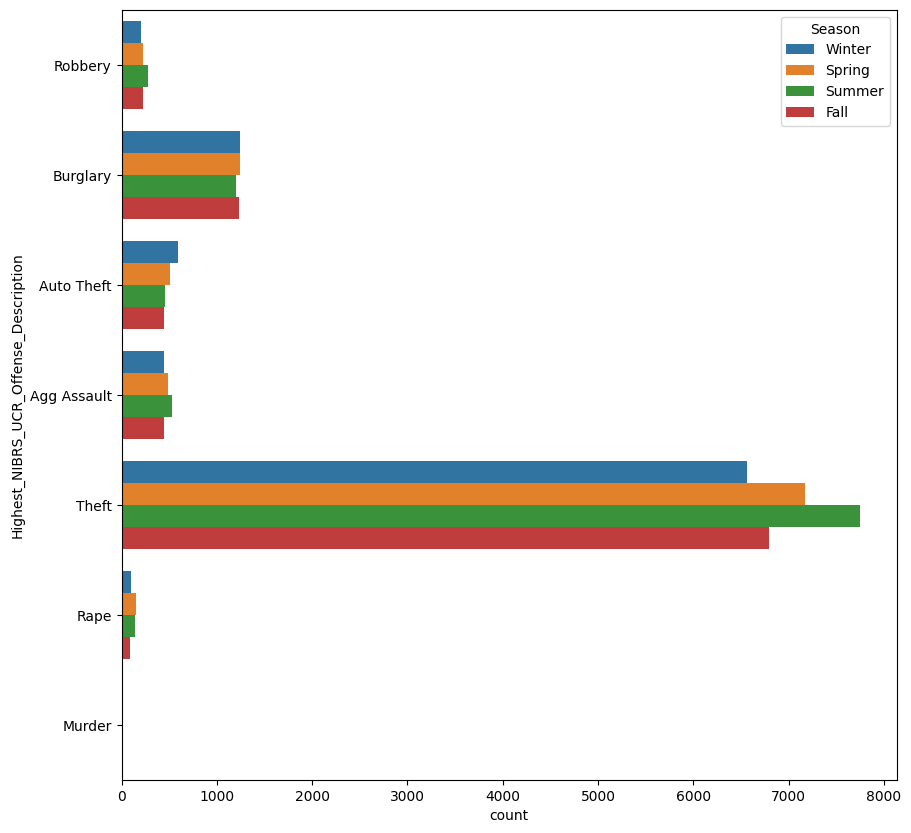

In [5]:
# Horizontal chart of crimes by season
plt.figure(figsize=(10, 10))
sns.countplot(y='Highest_NIBRS_UCR_Offense_Description', hue='Season', data=crime)

,Season,Report_Date
0,Fall,9257
1,Spring,9802
2,Summer,10362
3,Winter,9152


Text(0.5, 1.0, 'Number of crimes each day')

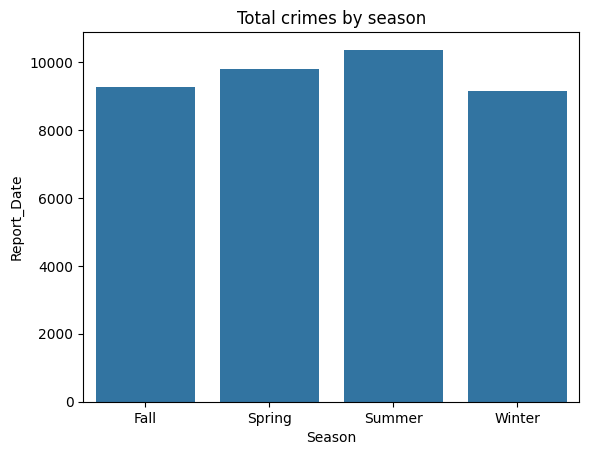

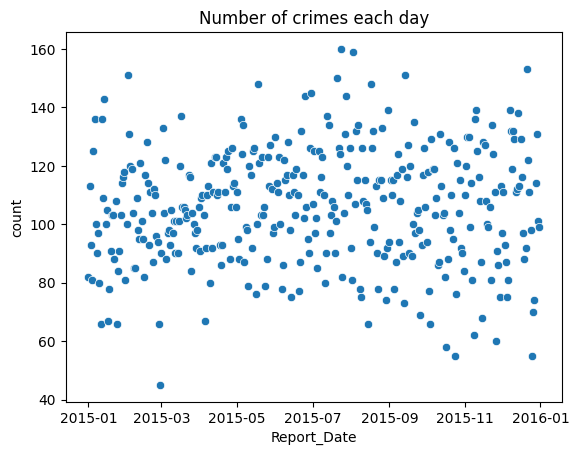

In [6]:
season_counts = crime.groupby('Season').agg({'Report_Date':'size'}).reset_index()
display(season_counts)
day_counts = crime.groupby(['Report_Date', 'Season']).size().reset_index(name='count')
sns.barplot(data=season_counts, x='Season', y='Report_Date')
plt.title('Total crimes by season')
plt.figure()
sns.scatterplot(data=day_counts, x='Report_Date', y='count')
plt.title('Number of crimes each day')

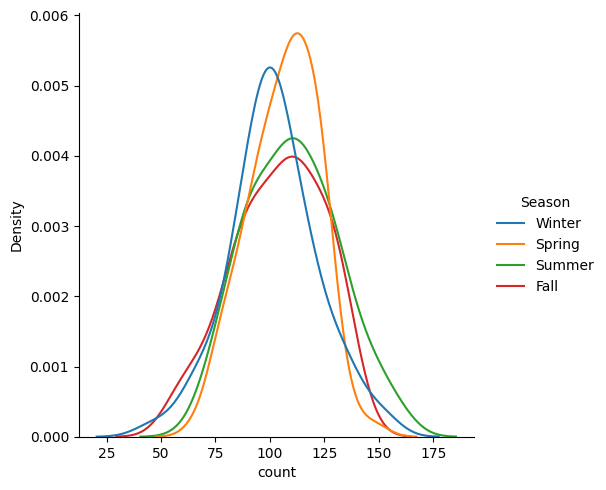

In [7]:
day_counts['count']
sns.displot(data=day_counts, x='count', kind='kde', hue='Season')

Anova Assumptions: 
+ Data are normally distributed. Looks like it from the plots, and n is large.
+ Data have the same variance: Could test this more but probably good
+ Data are independent: The scatterplot above is evidence of this.


In [8]:
import scipy.stats as stats
#Significance threshold: .05
# Null hypothesis: all groups have the same population mean
display(stats.f_oneway(day_counts[day_counts['Season'] == 'Winter']['count'], 
               day_counts[day_counts['Season'] == 'Spring']['count'], 
               day_counts[day_counts['Season'] == 'Summer']['count'], 
               day_counts[day_counts['Season'] == 'Fall']['count']))


F_onewayResult(statistic=3.2090007482269205, pvalue=0.023182992543201643)

In [9]:
#We can do this since the anova gave a significant result.

tukey_pvalue = stats.tukey_hsd(day_counts[day_counts['Season'] == 'Winter']['count'], 
               day_counts[day_counts['Season'] == 'Spring']['count'], 
               day_counts[day_counts['Season'] == 'Summer']['count'], 
               day_counts[day_counts['Season'] == 'Fall']['count']).pvalue
tukey = pd.DataFrame(tukey_pvalue)
tukey.columns=['Winter', 'Spring', 'Summer', 'Fall']
display(tukey)
print('Winter avg crimes per day: ', 
      day_counts[day_counts['Season'] == 'Winter']['count'].mean(), 
      '\nSummer avg crimes per day: ', 
      day_counts[day_counts['Season'] == 'Summer']['count'].mean())

,Winter,Spring,Summer,Fall
0,1.000000,0.340942,0.017428,0.857850
1,0.340942,1.000000,0.573909,0.820966
2,0.017428,0.573909,1.000000,0.140611
3,0.857850,0.820966,0.140611,1.000000


Winter avg crimes per day:  101.68888888888888 
Summer avg crimes per day:  110.23404255319149


This shows that winter and summer are significantly different, but none of the others. Why?

+ Tourists might be easy targets; or they might bring extra crime
+ It's easier to go out and do things when it's warm vs when it's cold.

## Crime Type

In [10]:
crime_types = crime.groupby('Highest_NIBRS_UCR_Offense_Description')['Key'].nunique().reset_index(name='crime_sum')

/tmp/ipykernel_20008/3437932425.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  bar.set_xticklabels(bar.get_xticklabels(), rotation=0)


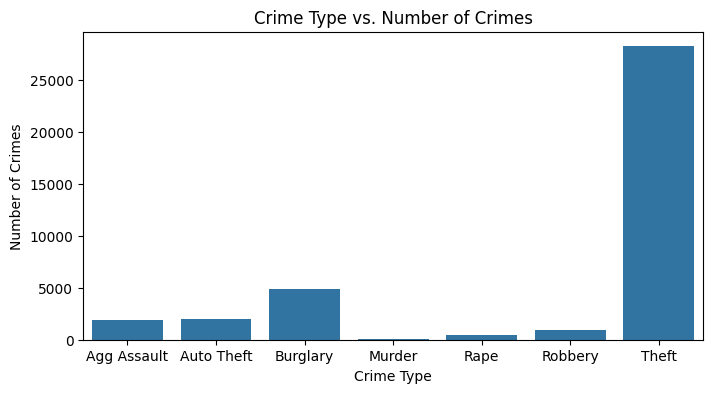

In [11]:
plt.figure(figsize=(8,4))
bar = sns.barplot(x='Highest_NIBRS_UCR_Offense_Description', y='crime_sum', data=crime_types)
bar.set_xticklabels(bar.get_xticklabels(), rotation=0)
bar.set(xlabel='Crime Type', ylabel='Number of Crimes', title='Crime Type vs. Number of Crimes')
plt.show()

## Crimes by Season

In [12]:
fall_crime = crime[crime['Season'] == 'Fall']
crime_types_fall = fall_crime.groupby('Highest_NIBRS_UCR_Offense_Description')['Key'].nunique().reset_index(name='crime_sum')

spring_crime = crime[crime['Season'] == 'Spring']
crime_types_spring = spring_crime.groupby('Highest_NIBRS_UCR_Offense_Description')['Key'].nunique().reset_index(name='crime_sum')

winter_crime = crime[crime['Season'] == 'Winter']
crime_types_winter = winter_crime.groupby('Highest_NIBRS_UCR_Offense_Description')['Key'].nunique().reset_index(name='crime_sum')

summer_crime = crime[crime['Season'] == 'Summer']
crime_types_summer = summer_crime.groupby('Highest_NIBRS_UCR_Offense_Description')['Key'].nunique().reset_index(name='crime_sum')

## Crime and Median Household Income

In [13]:
crime['Medianhouseholdincome'] = crime['Medianhouseholdincome'].str.replace('$', '').str.replace(' ', '').str.replace(',', '').astype('float')


In [14]:
crime['Medianhouseholdincome'].describe()

count     37444.000000
mean      50354.879367
std       20826.979519
min       11917.000000
25%       39593.000000
50%       41869.000000
75%       65672.000000
max      127726.000000
Name: Medianhouseholdincome, dtype: float64

In [15]:
def get_poor(median_income):
    if median_income <= 41869:
        return 1
    else:
        return 0

crime['poor_indicator'] = crime['Medianhouseholdincome'].apply(get_poor)

In [16]:
def get_severity(type):
    if type == 'Theft': #3.7 Years
        return 1
    elif type == 'Auto Theft': #4.0 Years
        return 2
    elif type == 'Agg Assault': #5.6 Years
        return 3
    elif type == 'Burglary': #5.8 Years
        return 4
    elif type == 'Robbery': #9.0 Years
        return 5
    elif type == 'Rape': #12.2 Years
        return 6
    elif type == 'Murder Crimes': #40.6 Years
        return 7

crime['severity_indicator'] = crime['Highest_NIBRS_UCR_Offense_Description'].apply(get_severity)

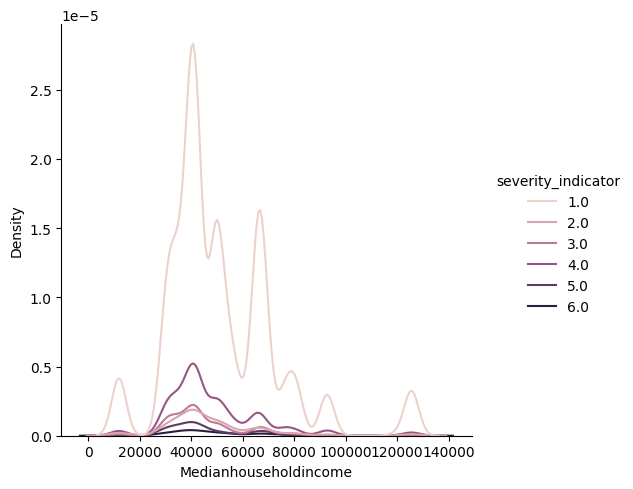

In [17]:
sns.displot(data=crime, x='Medianhouseholdincome', kind='kde', hue='severity_indicator')

Distributions are far from normal and the sample sizes are not close to being even.

## Median Income by Number of Crimes

In [18]:
pop_density = pd.read_csv('AustinZipCodes.csv')

In [19]:
zip_crime_counts = crime.groupby(['Medianhouseholdincome', 'Zip_Code_Crime']).size().reset_index(name='count')


In [20]:
zip_density = pd.merge(pop_density, zip_crime_counts, left_on='Zip Code', right_on='Zip_Code_Crime', how='inner')
zip_density['Population'] = zip_density['Population'].str.replace(',', '').astype(float)

<Axes: title={'center': 'Scatter Plot of Median Household Income by Crime Per Population (no outlier)'}, xlabel='Medianhouseholdincome', ylabel='crime_per_population'>

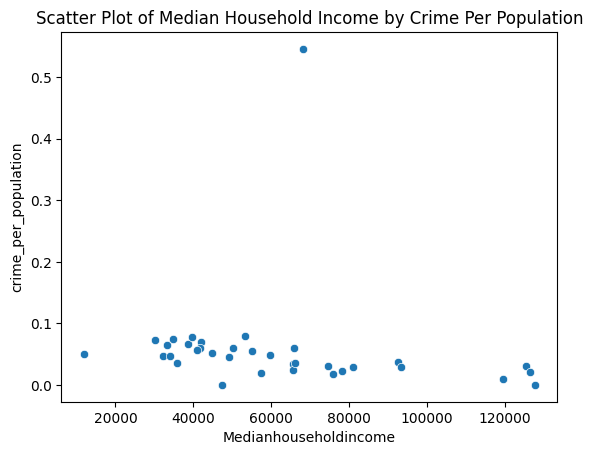

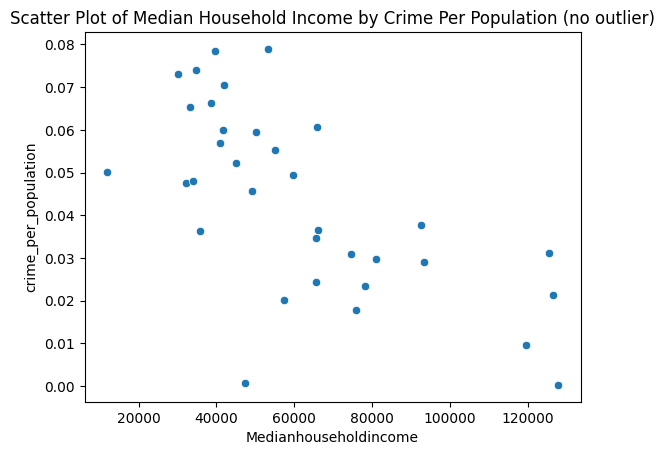

In [21]:
zip_density['crime_per_population'] = zip_density['count'] / zip_density['Population'].astype(int)
sns.scatterplot(data=zip_density, x='Medianhouseholdincome', y='crime_per_population')
plt.title('Scatter Plot of Median Household Income by Crime Per Population')
zip_density_no_outlier = zip_density[zip_density['crime_per_population'] < .5]
plt.figure()
plt.title('Scatter Plot of Median Household Income by Crime Per Population (no outlier)')
sns.scatterplot(data=zip_density_no_outlier, x='Medianhouseholdincome', y='crime_per_population')

In [22]:
stats.pearsonr(zip_density_no_outlier['Medianhouseholdincome'], zip_density_no_outlier['crime_per_population'])

PearsonRResult(statistic=-0.6583575925756773, pvalue=2.3126276203441627e-05)

In [23]:
crime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38573 entries, 0 to 38572
Data columns (total 46 columns):
 #   Column                                                                 Non-Null Count  Dtype         
---  ------                                                                 --------------  -----         
 0   Key                                                                    38573 non-null  int64         
 1   Council_District                                                       38401 non-null  float64       
 2   Highest_Offense_Desc                                                   38573 non-null  object        
 3   Highest_NIBRS_UCR_Offense_Description                                  38573 non-null  object        
 4   Report_Date                                                            38573 non-null  datetime64[ns]
 5   Location                                                               38092 non-null  object        
 6   Clearance_Status              

# Is there a relationship between affordable housing and different types of crime?

In [24]:
crime = crime.rename(
    columns={'Homesaffordabletopeopleearninglessthan$50000':'affordability_50k_pct',
             'Rentalsaffordabletopeopleearninglessthan$25000': 'rent_affordability_25k_pct'}
)
crime['affordability_50k_pct'] = crime['affordability_50k_pct'].str.replace('%', '').astype(float)
crime['rent_affordability_25k_pct'] = crime['rent_affordability_25k_pct'].str.replace('%', '').astype(float)

In [25]:
# Get zip code of crime against homes affordable to people earning less than $50,000
zip_affordable = crime[['Zip_Code_Crime', 'Zip_Code_Housing', 'affordability_50k_pct', 'rent_affordability_25k_pct']].drop_duplicates()
zip_affordable.head(15)

,Zip_Code_Crime,Zip_Code_Housing,affordability_50k_pct,rent_affordability_25k_pct
0,78753.0,78753.0,78.0,14.0
1,78751.0,78751.0,11.0,13.0
4,78744.0,78744.0,93.0,7.0
5,78741.0,78741.0,76.0,15.0
7,78727.0,78727.0,32.0,2.0
8,78721.0,78721.0,61.0,26.0
11,78759.0,78759.0,13.0,3.0
12,78757.0,78757.0,21.0,8.0
14,78752.0,78752.0,43.0,20.0
15,78758.0,78758.0,71.0,11.0


Dropping duplicates here looks at all columns by default so we aren't losing any valuable information.

It looks like all housing and crime zip codes are the same for non NaN rows. Let's just get the Zip_Code_Crime column and drop the Zip_Code_Housing one, since the former seems to be more complete, and drop the remaining NaN rows.

In [26]:
zip_afforable = zip_affordable.drop(columns=['Zip_Code_Housing']).dropna()
zip_afforable.head(10)

,Zip_Code_Crime,affordability_50k_pct,rent_affordability_25k_pct
0,78753.0,78.0,14.0
1,78751.0,11.0,13.0
4,78744.0,93.0,7.0
5,78741.0,76.0,15.0
7,78727.0,32.0,2.0
8,78721.0,61.0,26.0
11,78759.0,13.0,3.0
12,78757.0,21.0,8.0
14,78752.0,43.0,20.0
15,78758.0,71.0,11.0


In [27]:
# get counts of each type of crime in each zip code
crime_counts = crime.groupby(['Zip_Code_Crime', 'Highest_NIBRS_UCR_Offense_Description', ]).size().reset_index(name='counts')

zip_counts = zip_afforable.merge(right=crime_counts, on="Zip_Code_Crime")
zip_counts

,Zip_Code_Crime,affordability_50k_pct,rent_affordability_25k_pct,Highest_NIBRS_UCR_Offense_Description,counts
0,78753.0,78.0,14.0,Agg Assault,183
1,78753.0,78.0,14.0,Auto Theft,170
2,78753.0,78.0,14.0,Burglary,449
3,78753.0,78.0,14.0,Murder,3
4,78753.0,78.0,14.0,Rape,41
...,...,...,...,...,...
204,78739.0,0.0,0.0,Rape,2
205,78739.0,0.0,0.0,Theft,157
206,78732.0,0.0,0.0,Theft,1
207,78728.0,46.0,4.0,Agg Assault,1


In [28]:
# We need to account for population
pops = pd.read_csv('AustinZipCodes.csv')
pops = pops[['Zip Code', 'Population']].sort_values(by='Zip Code').reset_index(drop=True)
pops.head(10)

,Zip Code,Population
0,78701,"3,855"
1,78702,"22,534"
2,78703,"19,585"
3,78704,"43,249"
4,78705,"26,825"
5,78717,"8,148"
6,78719,"1,765"
7,78721,"10,124"
8,78722,"6,365"
9,78723,"30,110"


In [29]:
# Merge populations with zip_crime and calculate thefts per 1000 people
zip_crime_p1000 = zip_counts.merge(right=pops, left_on='Zip_Code_Crime', right_on='Zip Code').drop(columns=['Zip_Code_Crime'])
zip_crime_p1000

zip_crime_p1000['Population'] = zip_crime_p1000['Population'].str.replace(',', '').astype(int)
zip_crime_p1000['count_p1000'] = zip_crime_p1000['counts'] / zip_crime_p1000['Population'] * 1000 # Crime count per 1000 people
zip_crime_p1000

,affordability_50k_pct,rent_affordability_25k_pct,Highest_NIBRS_UCR_Offense_Description,counts,Zip Code,Population,count_p1000
0,78.0,14.0,Agg Assault,183,78753,44210,4.139335
1,78.0,14.0,Auto Theft,170,78753,44210,3.845284
2,78.0,14.0,Burglary,449,78753,44210,10.156073
3,78.0,14.0,Murder,3,78753,44210,0.067858
4,78.0,14.0,Rape,41,78753,44210,0.927392
...,...,...,...,...,...,...,...
204,0.0,0.0,Rape,2,78739,8643,0.231401
205,0.0,0.0,Theft,157,78739,8643,18.164989
206,0.0,0.0,Theft,1,78732,3629,0.275558
207,46.0,4.0,Agg Assault,1,78728,17298,0.057810


PearsonRResult(statistic=-0.031428082956386855, pvalue=0.8577629056383981)

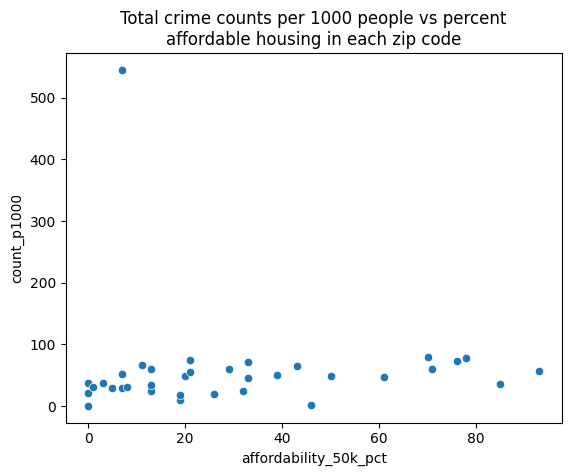

In [30]:
total_crime_p1000 = zip_crime_p1000.groupby(['Zip Code', 'affordability_50k_pct', 'rent_affordability_25k_pct']).agg({'count_p1000': 'sum'}).reset_index()

sns.scatterplot(data=total_crime_p1000, x='affordability_50k_pct', y='count_p1000')
plt.title("Total crime counts per 1000 people vs percent\naffordable housing in each zip code")

# now do a pearson correlation
pearsonr(total_crime_p1000['affordability_50k_pct'], total_crime_p1000['count_p1000'])

,Zip Code,affordability_50k_pct,rent_affordability_25k_pct,count_p1000
0,78701,7.0,7.0,545.525292


PearsonRResult(statistic=0.46042788717972677, pvalue=0.0061420016371019175)

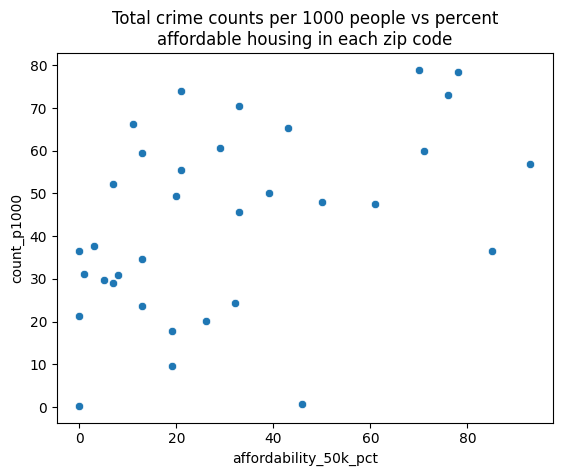

In [31]:
# note the outlier
display(total_crime_p1000[total_crime_p1000['count_p1000'] > 400])

# Get rid of the outlier
total_crime_no_outlier = total_crime_p1000[total_crime_p1000['count_p1000'] < 400]
sns.scatterplot(data=total_crime_no_outlier, x='affordability_50k_pct', y='count_p1000')
plt.title("Total crime counts per 1000 people vs percent\naffordable housing in each zip code")

# now do a pearson correlation
pearsonr(total_crime_no_outlier['affordability_50k_pct'], total_crime_no_outlier['count_p1000'])

## Different types of crime vs affordable housing

### Burglary

PearsonRResult(statistic=0.4246343633082442, pvalue=0.013773790298893624)

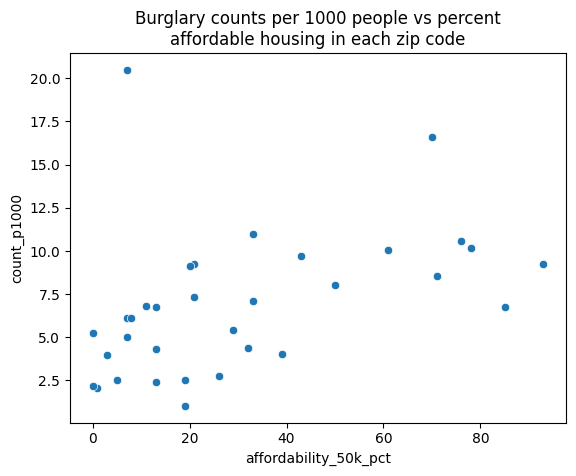

In [32]:
# Get burglaries per 1000 people against affordability
burglary_p1000_housing = zip_crime_p1000[zip_crime_p1000['Highest_NIBRS_UCR_Offense_Description'] == 'Burglary']

sns.scatterplot(data=burglary_p1000_housing, x='affordability_50k_pct', y='count_p1000')
plt.title("Burglary counts per 1000 people vs percent\naffordable housing in each zip code")

# now do a pearson correlation
pearsonr(burglary_p1000_housing['affordability_50k_pct'], burglary_p1000_housing['count_p1000'])

,affordability_50k_pct,rent_affordability_25k_pct,Highest_NIBRS_UCR_Offense_Description,counts,Zip Code,Population,count_p1000
81,7.0,7.0,Burglary,79,78701,3855,20.492866


PearsonRResult(statistic=0.643821273643408, pvalue=7.019883986031093e-05)

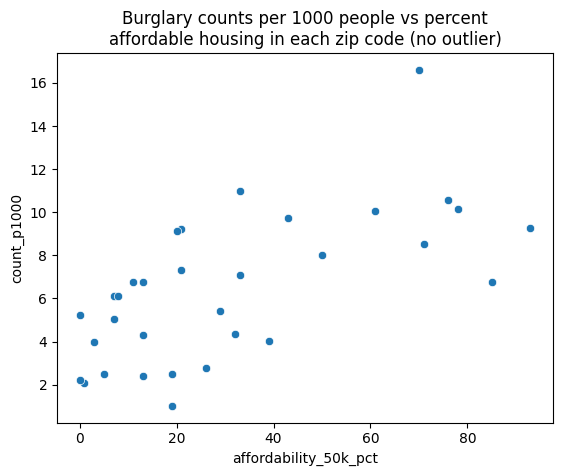

In [33]:
# Note the obvious outliers
display(burglary_p1000_housing[burglary_p1000_housing['count_p1000'] > 20])

# Remove the outlier
burglary_no_outliers = burglary_p1000_housing[burglary_p1000_housing['count_p1000'] < 20]
sns.scatterplot(data=burglary_no_outliers, x='affordability_50k_pct', y='count_p1000')
plt.title("Burglary counts per 1000 people vs percent\naffordable housing in each zip code (no outlier)")

# now do a pearson correlation
pearsonr(burglary_no_outliers['affordability_50k_pct'], burglary_no_outliers['count_p1000'])

### Theft

PearsonRResult(statistic=-0.07704723350782015, pvalue=0.6599961611202827)

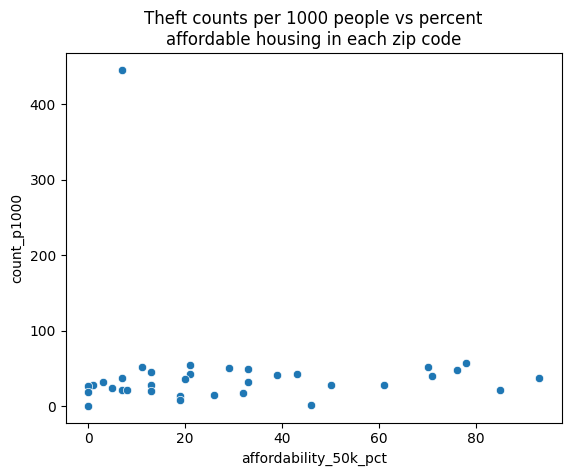

In [34]:
# Get thefts per 1000 people against affordability
theft_p1000_housing = zip_crime_p1000[zip_crime_p1000['Highest_NIBRS_UCR_Offense_Description'] == 'Theft']

sns.scatterplot(data=theft_p1000_housing, x='affordability_50k_pct', y='count_p1000')
plt.title("Theft counts per 1000 people vs percent\naffordable housing in each zip code")

# now do a pearson correlation
pearsonr(theft_p1000_housing['affordability_50k_pct'], theft_p1000_housing['count_p1000'])

,affordability_50k_pct,rent_affordability_25k_pct,Highest_NIBRS_UCR_Offense_Description,counts,Zip Code,Population,count_p1000
85,7.0,7.0,Theft,1718,78701,3855,445.654994


PearsonRResult(statistic=0.32313051204527854, pvalue=0.06231604029784376)

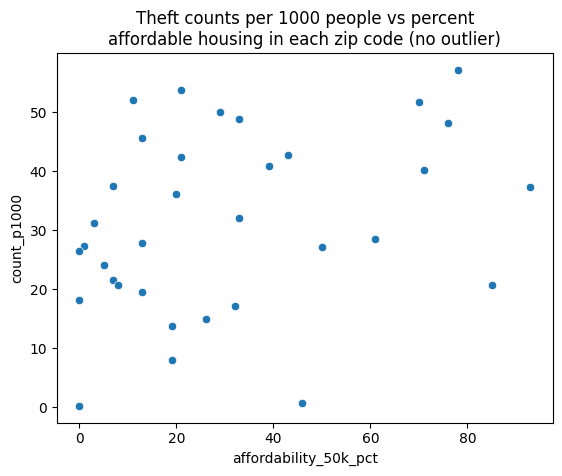

In [35]:
# Note the obvious outlier
display(theft_p1000_housing[theft_p1000_housing['count_p1000'] > 100])

# Remove the outlier
theft_no_outliers = theft_p1000_housing[theft_p1000_housing['count_p1000'] < 100]
sns.scatterplot(data=theft_no_outliers, x='affordability_50k_pct', y='count_p1000')
plt.title("Theft counts per 1000 people vs percent\naffordable housing in each zip code (no outlier)")

# now do a pearson correlation
pearsonr(theft_no_outliers['affordability_50k_pct'], theft_no_outliers['count_p1000'])

# What about rental housing?

PearsonRResult(statistic=0.08915776186730764, pvalue=0.6105246974688772)

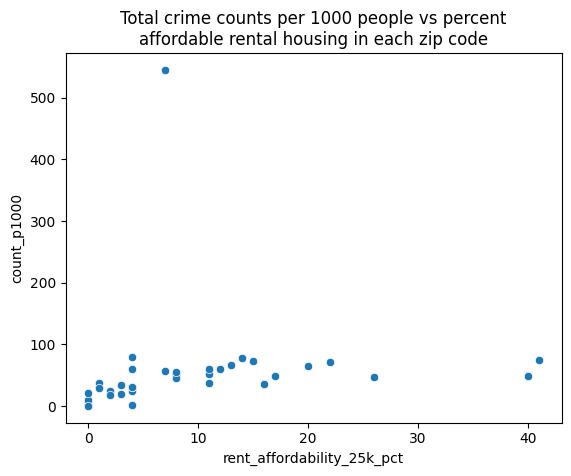

In [36]:
sns.scatterplot(data=total_crime_p1000, x='rent_affordability_25k_pct', y='count_p1000')
plt.title("Total crime counts per 1000 people vs percent\naffordable rental housing in each zip code")

# Pearson correlation
pearsonr(total_crime_p1000['rent_affordability_25k_pct'], total_crime_p1000['count_p1000'])

,Zip Code,affordability_50k_pct,rent_affordability_25k_pct,count_p1000
0,78701,7.0,7.0,545.525292


PearsonRResult(statistic=0.557145718174636, pvalue=0.000620147366272815)

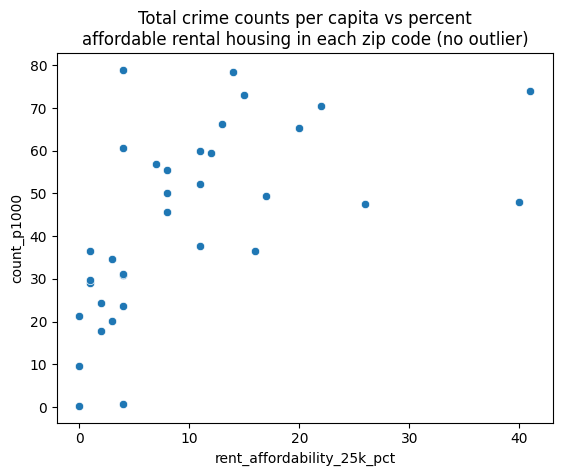

In [37]:
# Note the outlier
display(total_crime_p1000[total_crime_p1000['count_p1000'] > 400])

# Get rid of the outlier
total_crime_no_outlier = total_crime_p1000[total_crime_p1000['count_p1000'] < 400]
sns.scatterplot(data=total_crime_no_outlier, x='rent_affordability_25k_pct', y='count_p1000')
plt.title("Total crime counts per capita vs percent\naffordable rental housing in each zip code (no outlier)")

# Pearson correlation
pearsonr(total_crime_no_outlier['rent_affordability_25k_pct'], total_crime_no_outlier['count_p1000'])

### Burglary

PearsonRResult(statistic=0.3834261106376966, pvalue=0.02762000675928735)

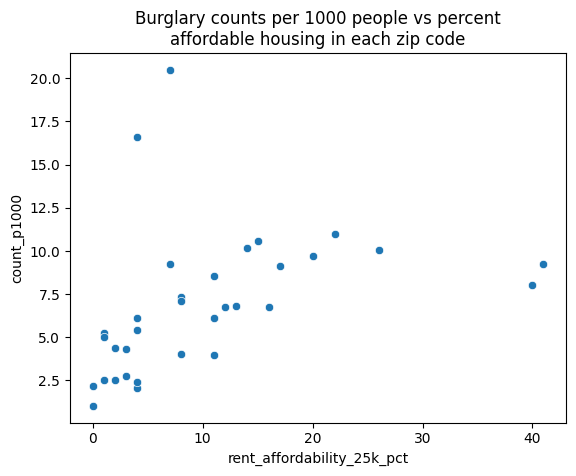

In [38]:
# Get burglaries per 1000 people against affordability
burglary_p1000_rental = zip_crime_p1000[zip_crime_p1000['Highest_NIBRS_UCR_Offense_Description'] == 'Burglary']

sns.scatterplot(data=burglary_p1000_rental, x='rent_affordability_25k_pct', y='count_p1000')
plt.title("Burglary counts per 1000 people vs percent\naffordable housing in each zip code")

# do a pearson correlation
pearsonr(burglary_p1000_rental['rent_affordability_25k_pct'], burglary_p1000_rental['count_p1000'])

,affordability_50k_pct,rent_affordability_25k_pct,Highest_NIBRS_UCR_Offense_Description,counts,Zip Code,Population,count_p1000
81,7.0,7.0,Burglary,79,78701,3855,20.492866
182,70.0,4.0,Burglary,90,78754,5422,16.599041


PearsonRResult(statistic=0.6904193900150132, pvalue=1.7208619416039936e-05)

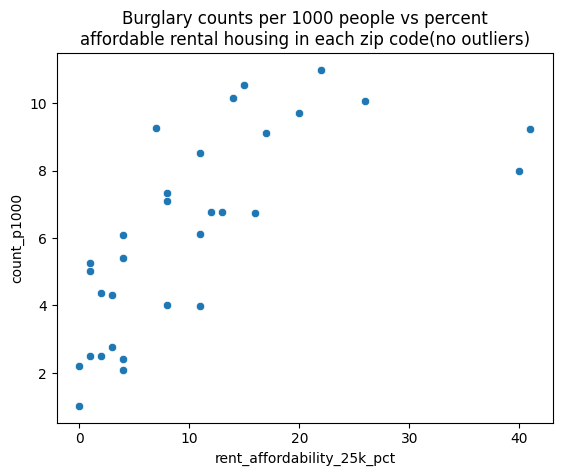

In [39]:
# Note the outliers above 15
display(burglary_p1000_rental[burglary_p1000_rental['count_p1000'] > 15])

# Remove the outliers
burglary_no_outliers = burglary_p1000_rental[burglary_p1000_rental['count_p1000'] < 15]
sns.scatterplot(data=burglary_no_outliers, x='rent_affordability_25k_pct', y='count_p1000')
plt.title("Burglary counts per 1000 people vs percent\naffordable rental housing in each zip code(no outliers)")

# do a pearson correlation
pearsonr(burglary_no_outliers['rent_affordability_25k_pct'], burglary_no_outliers['count_p1000'])

### Theft

PearsonRResult(statistic=0.05061138429381715, pvalue=0.7727865827305922)

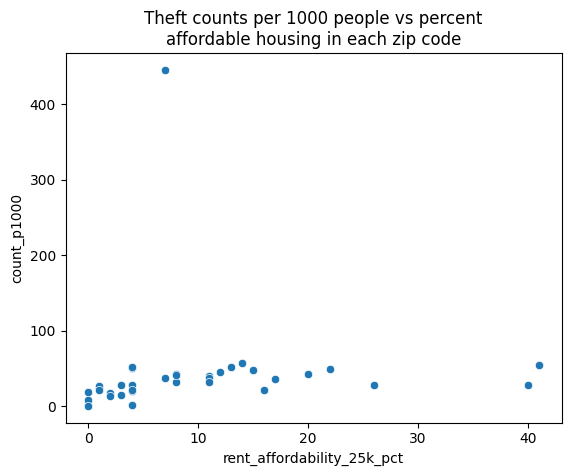

In [40]:
# Plot thefts per capita per 1000 people against affordability
theft_p1000_rental = zip_crime_p1000[zip_crime_p1000['Highest_NIBRS_UCR_Offense_Description'] == 'Theft']

sns.scatterplot(data=theft_p1000_rental, x='rent_affordability_25k_pct', y='count_p1000')
plt.title("Theft counts per 1000 people vs percent\naffordable housing in each zip code")

# do a pearson correlation
pearsonr(theft_p1000_rental['rent_affordability_25k_pct'], theft_p1000_rental['count_p1000'])

,affordability_50k_pct,rent_affordability_25k_pct,Highest_NIBRS_UCR_Offense_Description,counts,Zip Code,Population,count_p1000
85,7.0,7.0,Theft,1718,78701,3855,445.654994


PearsonRResult(statistic=0.46807045020228444, pvalue=0.005243953233590679)

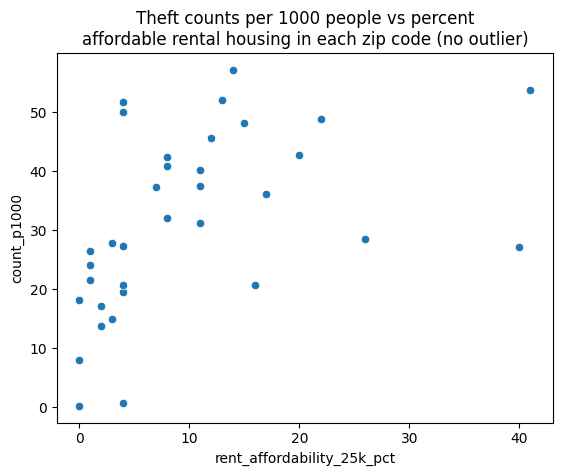

In [41]:
# Note the outliers above 15
display(theft_p1000_rental[theft_p1000_rental['count_p1000'] > 100])

# Remove the outliers
theft_no_outliers = theft_p1000_rental[theft_p1000_rental['count_p1000'] < 100]
sns.scatterplot(data=theft_no_outliers, x='rent_affordability_25k_pct', y='count_p1000')
plt.title("Theft counts per 1000 people vs percent\naffordable rental housing in each zip code (no outlier)")

# do a pearson correlation
pearsonr(theft_no_outliers['rent_affordability_25k_pct'], theft_no_outliers['count_p1000'])

# Cool extra thing

<Axes: xlabel='X_Coordinate', ylabel='Y_Coordinate'>

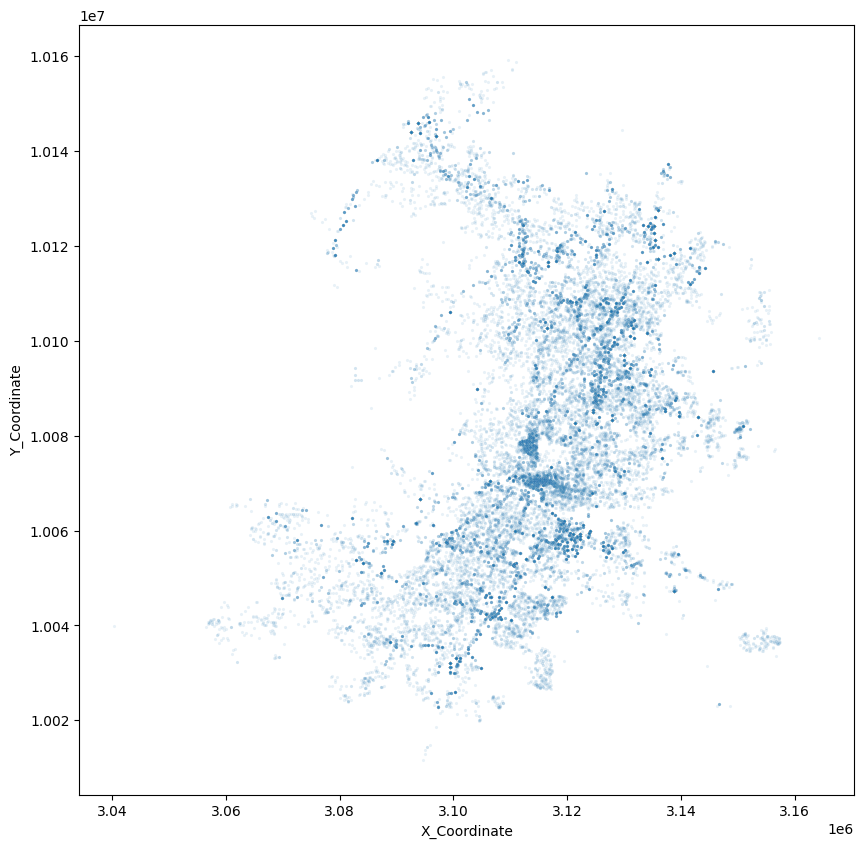

In [42]:
# Plot crimes by x and y coordinates
plt.figure(figsize=(10, 10))
sns.scatterplot(x='X_Coordinate', y='Y_Coordinate', data=crime, alpha=0.1, s=5)